In [78]:
 from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import matplotlib.pyplot as plt
import yaml
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import sqlalchemy

In [22]:
with open('credentials.yaml', 'r') as f:
    credentials = yaml.safe_load(f)

In [23]:
class RDSDatabaseConnector:
    def __init__(self, credentials):
        self.credentials = credentials

    def _create_engine(self):
        engine = create_engine(f"postgresql+psycopg2://{self.credentials['RDS_USER']}:{self.credentials['RDS_PASSWORD']}@{self.credentials['RDS_HOST']}:{self.credentials['RDS_PORT']}/{self.credentials['RDS_DATABASE']}")
        return engine
    
    def initialise_engine(self):
        self.engine = self._create_engine()

    def data_extraction(self, table_name='loan_payments'):
        query = f"SELECT * FROM loan_payments;"
        data = pd.read_sql(query, self.engine)
        return data
    
    def save_to_file(self, data, file_path='loan_payments_data.csv'):
        data.to_csv(file_path, index=False)

    def load_loan_data(self, file_path='loan_payments_data.csv'):
        try:
            return pd.read_csv(file_path)
        except FileNotFoundError:
            print(f"Error: File '{file_path}' not found.")
            return None


In [24]:
loan_data = RDSDatabaseConnector(credentials)
loan_data._create_engine()
loan_data.initialise_engine()
loan_data.data_extraction()
loan_data.data_extraction('loan_payments')
loan_data.save_to_file(data=loan_data.data_extraction('loan_payments'), file_path='loan_payments_data.csv')
loaded_data = loan_data.load_loan_data('loan_payments_data.csv')

In [25]:
loans_df = pd.read_csv('loan_payments_data.csv', index_col='id')
loans_df.tail(10).describe()
loans_df['recoveries']


id
38676116      0.00
38656203      0.00
38656154      0.00
38656128      0.00
38656121      0.00
             ...  
76597         0.00
142608        0.00
117045        0.00
88854         0.00
72323       182.27
Name: recoveries, Length: 54231, dtype: float64

In [26]:
loans_df['term'] = loans_df['term'].str.replace('months', '', regex=True)
loans_df['employment_length'] = loans_df['employment_length'].str.replace('years', '', regex=True)
loans_df['employment_length'] = loans_df['employment_length'].str.replace('year', '', regex=True)

In [27]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54231 entries, 38676116 to 72323
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   member_id                    54231 non-null  int64  
 1   loan_amount                  54231 non-null  int64  
 2   funded_amount                51224 non-null  float64
 3   funded_amount_inv            54231 non-null  float64
 4   term                         49459 non-null  object 
 5   int_rate                     49062 non-null  float64
 6   instalment                   54231 non-null  float64
 7   grade                        54231 non-null  object 
 8   sub_grade                    54231 non-null  object 
 9   employment_length            52113 non-null  object 
 10  home_ownership               54231 non-null  object 
 11  annual_inc                   54231 non-null  float64
 12  verification_status          54231 non-null  object 
 13  issue_date    

<Axes: >

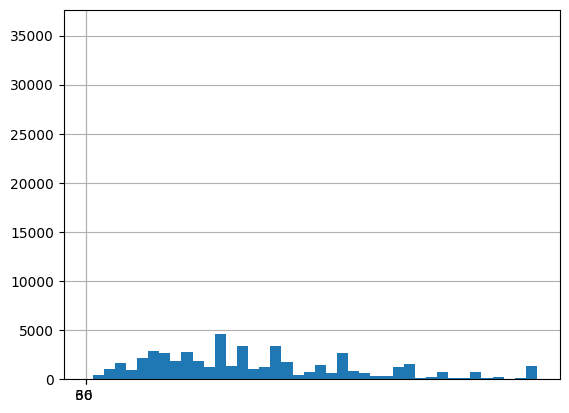

In [28]:
loans_df['funded_amount'].hist(bins=40)
loans_df['term'].hist(bins=40)
loans_df['int_rate'].hist(bins=40)

In [29]:
class DataFrameTransform:
    def __init__(self, loans_df):
        self.loans_df = loans_df
    
    def identify_skewed_columns(self, threshold=0.5):
        skewed_columns = self.loans_df.apply(lambda x: abs(x.skew()) > threshold)
        return skewed_columns[skewed_columns].index.tolist()

    def visualize_skewness(self, columns, plotter):
        for column in columns:
            plotter.plot_distribution(self.loans_df, column)

    def transform_columns(self, columns, transformation):
        for column in columns:
            if pd.api.types.is_numeric_dtype(self.loans_df[column]):
                self.loans_df[column] = transformation(self.loans_df[column])
            else:
                pass
    
    def null_impute(self, loans_df):
        for column in loans_df.columns:
                if pd.api.types.is_numeric_dtype(self.loans_df[column]):
                    if loans_df[column].isnull().any():
                     if loans_df[column].dtype == 'float64':
                        loans_df[column].fillna(loans_df[column].median(), inplace=True)
                    else:
                        loans_df[column].fillna(loans_df[column].mode()[0], inplace=True)
        return loans_df
    
    def save_transformed_data(self, filename='transformed_data.csv'):
        self.loans_df.to_csv(filename, index=False)

transform = DataFrameTransform(loans_df)
threshold_skewness = 0.5 
skewed_columns = transform.identify_skewed_columns(threshold_skewness)
transform.save_transformed_data('transformed_data.csv', index=False)



TypeError: could not convert string to float: 'A'

['member_id', 'term', 'int_rate', 'grade', 'sub_grade', 'employment_length', 'home_ownership', 'verification_status', 'issue_date', 'loan_status', 'payment_plan', 'purpose', 'dti', 'delinq_2yrs', 'earliest_credit_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'total_accounts', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_payment_date', 'last_payment_amount', 'next_payment_date', 'last_credit_pull_date', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type']


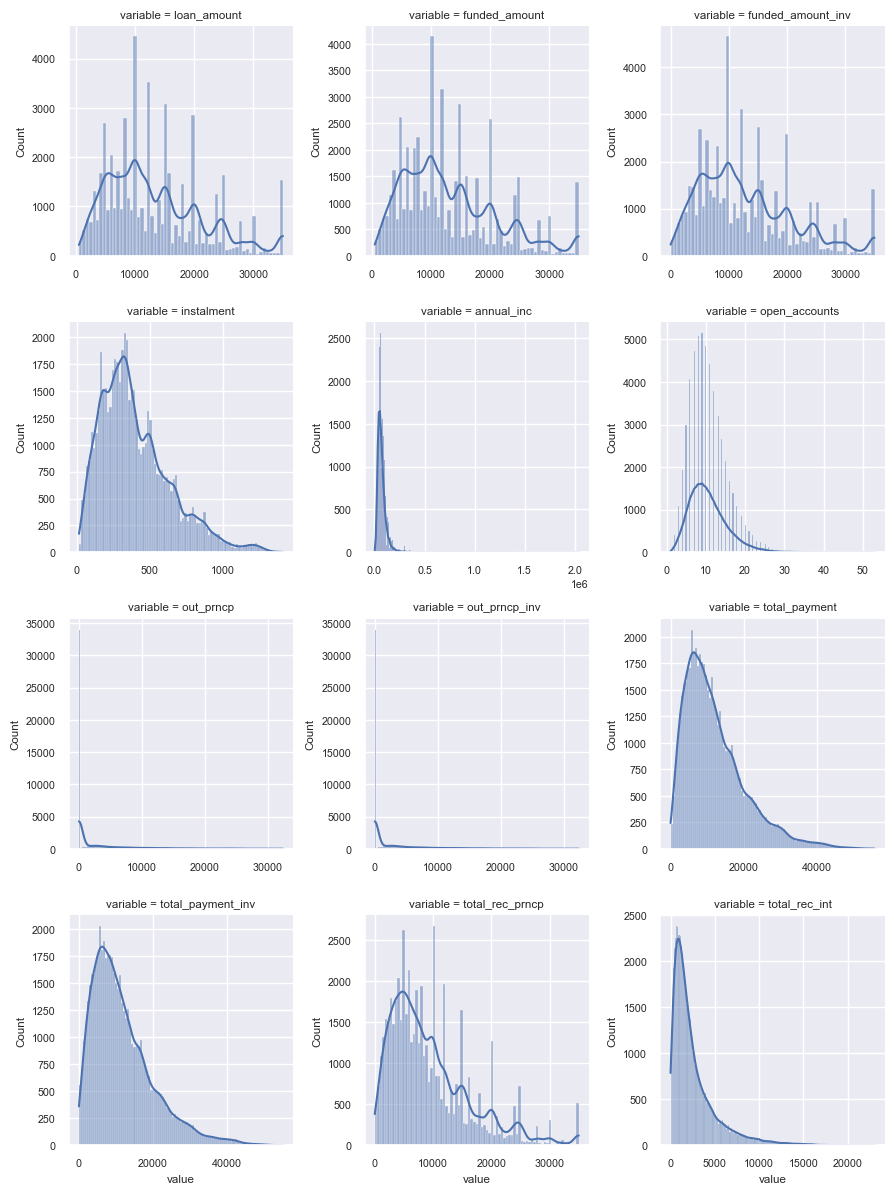

In [ ]:
from matplotlib import pyplot
import seaborn as sns
from scipy.stats import normaltest
class Plotter:
    def __init__(self, loans_df):
        self.loans_df = loans_df
    
    def plot_distribution(self, data, column):
        pass
    
    def null_percent_funded(self):
        return loans_df['funded_amount'].isnull().sum() * 100/len(loans_df['funded_amount'])
        loans_df['funded_amount'].hist(bins=40)
    
    def null_percent_term(self):
        return loans_df['term'].isnull().sum() * 100/len(loans_df['term'])
    
    def null_percent_int_rate(self):
        return loans_df['int_rate'].isnull().sum() * 100/len(loans_df['int_rate'])
        
    def skew_check(self):
        numeric_data = ['loan_amount',
                    'funded_amount', 
                    'funded_amount_inv',
                    'instalment',
                    'annual_inc',
                    'open_accounts',
                    'out_prncp',
                    'out_prncp_inv',
                    'total_payment',
                    'total_payment_inv',
                    'total_rec_prncp',
                    'total_rec_int'
                    ]

        categorical_data = [col for col in loans_df.columns if col not in numeric_data]
        sns.set(font_scale=0.7)
        f = pd.melt(loans_df, value_vars=numeric_data)
        g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
        g = g.map(sns.histplot, "value", kde=True)
        print(categorical_data)
    
plotting = Plotter(loans_df)
plotting.null_percent_funded()
plotting.null_percent_term()
plotting.null_percent_int_rate()
plotting.skew_check()


Imputing null values done 
outlier removal (not done_ )
coreelated collumns (not done)


In [ ]:
class Nulls:
    def __init__(self, loans_df):
        self.loans_df = loans_df

    def null_impute(self, loans_df):
        for column in loans_df.columns:
                if loans_df[column].isnull().any():
                    if loans_df[column].dtype == 'float64':
                        loans_df[column].fillna(loans_df[column].median(), inplace=True)
                    else:
                        loans_df[column].fillna(loans_df[column].mode()[0], inplace=True)
                return loans_df
    
imputing_nulls = Nulls(loans_df)


Checking for skewdness

In [ ]:
class Loan_analysis:
    def __init__(self, loans_df):
        self.loans_df = loans_df
    
    
        loans_df['total_payment'].sum()/loans_df['funded_amount_inv'].sum() * 100
        loans_df[loans_df['months_to_recovery'] <= 6]['total_payment'].sum() / loans_df['loan_amount'].sum() * 100
        label = ['Overall Recovery', 'Recovery Up to 6 Months']
        percentages = ['percent_recovery', 'percent_recovery_up_to_6_months']



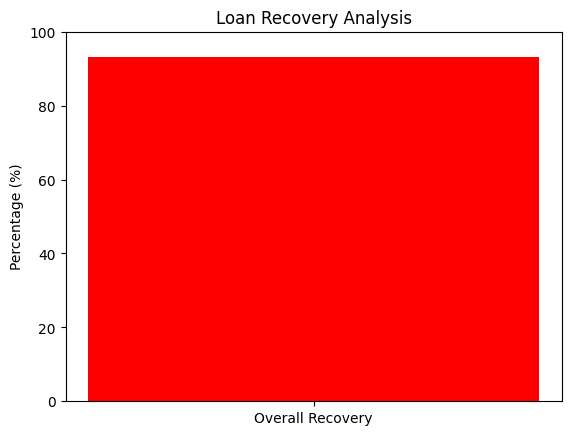

In [ ]:
percent_recovery = loans_df['total_payment'].sum()/loans_df['funded_amount_inv'].sum() * 100
labels = ['Overall Recovery']
percentages = [percent_recovery]
plt.bar(labels, percentages, color=['red', 'blue'])
plt.ylabel('Percentage (%)')
plt.title('Loan Recovery Analysis')
plt.ylim(0, 100)
plt.show()

ask about below

milestone 4 task 3
percentage off loans that were charged off and amound paid before charged off

In [80]:
loan_loss = len(loans_df[loans_df['loan_status'] == 'Charged Off'])
percentage_loan_loss = (loan_loss/len(loans_df)) * 100 
print(loan_loss)
print(round(percentage_loan_loss, 2), '%')
paid_until_charged_off = loans_df.loc[loans_df['loan_status'] == 'Charged Off', 'total_payment']
print(paid_until_charged_off)


5571
10.27 %
id
38656067     4182.270000
38654836     1906.510000
38645937      282.780000
38645713     1808.050000
38644867     1654.140000
                ...     
127830       7294.650000
127472       2580.248838
118533       2086.630000
113179        703.950000
111227      20339.660000
Name: total_payment, Length: 5571, dtype: float64


milestone 4 task 3
projected loan_loss 
logic  = amount left to pay before charged off (total loan - total paid = leftover to pay) then sum to show loss of amount?

In [94]:
sum_paid_until_charged_off = loans_df.loc[loans_df['loan_status'] == 'Charged Off', 'total_payment'].sum() #amount of money total remaining for loans that were charged off 
total_loan_charged_off = loans_df.loc[loans_df['loan_status'] == 'Charged Off', 'loan_amount'].sum()
projected_loss = total_loan_charged_off - sum_paid_until_charged_off
print(projected_loss)

38958810.959180504


In [119]:
late = loans_df[loans_df['loan_status'].str.contains('late', case=False)] #Extracting the collumns where the contents of the loan status collunm is late
money_owed_late_payments = late['out_prncp'].sum() #loss to company if late payers status changed to charged off
print(money_owed_late_payments)
len(loans_df) #extracting the number of loanees total
number_of_late_payers = len(late) #number of loanees who have late payments
total_loanees = len(loans_df)
percentage_owed_over_total = (number_of_late_payers/total_loanees) * 100 #calculates how much of the total loanees the late payees make up 
percentage_owed_over_total_rounded = round(percentage_owed_over_total, 2)
print(percentage_owed_over_total_rounded, '%')

          member_id  loan_amount  funded_amount  funded_amount_inv term  \
id                                                                        
38655869   41439673        18825        18825.0       18825.000000  60    
38644147   41427862        15600        15600.0       15600.000000  36    
38635317   41419102         6000         6000.0        6000.000000  36    
38635273   41419056        15000        15000.0       15000.000000  36    
38625326   41409103         5000         5000.0        5000.000000  36    
...             ...          ...            ...                ...  ...   
635663       814313        12000        12000.0       11793.180807  60    
624521       800330        15000        15000.0       14975.000000  60    
601614       771967        18000        18000.0       17900.000000  60    
595187       764195        12000        12000.0       11950.000000  60    
560150       720996        25000        25000.0       24975.000000  60    

          int_rate  inst

54231

1.26 %
54231
686


In [143]:
#LATE/ALL LOAN 
percentage_owed_over_total_late = round(percentage_owed_over_total, 2)
percentage_owed_over_total_charged_off = round(percentage_loan_loss, 2)
print(f"The percentage of payments in the dataframe that are late is {percentage_owed_over_total}, %")
print(f"The percentage of payments in the dataframe that are charged off is {percentage_owed_over_total_charged_off}, %")

money_owed_charged_off = loans_df.loc[loans_df['loan_status'] == 'Charged Off', 'loan_amount'].sum() - loans_df.loc[loans_df['loan_status'] == 'Charged Off', 'total_payment'].sum()
print(f'1 {money_owed_charged_off}')
print(f'2 {money_owed_late_payments}')
money_owed_charged_off_and_late = (money_owed_late_payments + money_owed_charged_off)/ loans_df['loan_amount'].sum() * 100
money_owed_charged_off_and_late_rounded = round(money_owed_charged_off_and_late)
print(f'The percentage of total expected revenue represented by people whose loan status is charged off and late is {money_owed_charged_off_and_late}')

The percentage of payments in the dataframe that are late is 1.2649591562021723, %
The percentage of payments in the dataframe that are charged off is 10.27, %
1 38958810.959180504
2 6024730.62
The percentage of total expected revenue by people whose loan status is charged off and late is 6.22122164070357


milestone 4 task 4
There are customers who are currently behind with their loan payments. This subset of customers represent a risk to company revenue.

1. so look at th collumns where the loan is late then calculate that as a percentage of total collumns (people) then calculate how much they owe total (leftover to pay) DONE 

What percentage do users' in this bracket currently represent as a percentage of all loans? DONE 1.2% Calculate the total amount of customers in this bracket
how much loss the company would incur their status was changed to Charged Off DONE
What is the projected loss of these loans if the customer were to finish the full loans term? (CONFUSED)

2. percentage off late and charged off against all loans (how much do the people reprsetn so collumn number not sum total)
-DONE

If customers late on payments converted to Charged Off, what percentage of total expected revenue do these customers
and the customers who have already defaulted on their loan represent? DONE
 

Milestone 4 task 5
In this task you will be analysing the data to visualise the possible indicators that a customer will not be able to pay the loan.

You will want to compare columns which might be indicators against customers who have already stopped paying and customers who are currently behind on payments.


Here are some example columns that might indicate that a user might not pay the loan:

Does the grade of the loan have effect on customers not paying?
Is the purpose for the loan likely to have an effect?
Does the home_ownership value contribute to the likelihood a customer won't pay?
To help identify which columns will be of interest, create a subset of these users.


Make the analysis and determine the columns are contributing to loans not being paid off and visualise any interesting indicators.

Compare these indicators between loans already charged off and loans which could change to charged off to check if these same factors apply to loans which have the potential to change to "Charged Off".

1. basicaly analyse loans and see if anything influences the charged off loan status 

In [146]:
a = loans_df.loc[loans_df['loan_status'] == 'fully paid']
print(a)

Empty DataFrame
Columns: [member_id, loan_amount, funded_amount, funded_amount_inv, term, int_rate, instalment, grade, sub_grade, employment_length, home_ownership, annual_inc, verification_status, issue_date, loan_status, payment_plan, purpose, dti, delinq_2yrs, earliest_credit_line, inq_last_6mths, mths_since_last_delinq, mths_since_last_record, open_accounts, total_accounts, out_prncp, out_prncp_inv, total_payment, total_payment_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_payment_date, last_payment_amount, next_payment_date, last_credit_pull_date, collections_12_mths_ex_med, mths_since_last_major_derog, policy_code, application_type]
Index: []

[0 rows x 42 columns]


In [144]:
print(late)


          member_id  loan_amount  funded_amount  funded_amount_inv term  \
id                                                                        
38655869   41439673        18825        18825.0       18825.000000  60    
38644147   41427862        15600        15600.0       15600.000000  36    
38635317   41419102         6000         6000.0        6000.000000  36    
38635273   41419056        15000        15000.0       15000.000000  36    
38625326   41409103         5000         5000.0        5000.000000  36    
...             ...          ...            ...                ...  ...   
635663       814313        12000        12000.0       11793.180807  60    
624521       800330        15000        15000.0       14975.000000  60    
601614       771967        18000        18000.0       17900.000000  60    
595187       764195        12000        12000.0       11950.000000  60    
560150       720996        25000        25000.0       24975.000000  60    

          int_rate  inst

go back somehting was wrong
 outliers not removed and also something esle

 then add docustrings to explain code update readme and you're good